<a href="https://colab.research.google.com/github/FilledEther20/Feature_Selection_Hybrid_MPA-CFHO/blob/main/Feature_Selection_Intern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports & Docs Initialized



In [ ]:
!pip install mealpy
import numpy as np
import math
import mealpy
from mealpy import FloatVar, MPA, PSO
import matplotlib.pyplot as plt
import random
# print(mealpy.__version__)
# print(np.__version__)
import logging
# Set logging level to WARNING or ERROR to suppress INFO messages
logging.getLogger('mealpy').setLevel(logging.WARNING)

#Chaotic Maps Defined

In [ ]:
def logistic_map(x):
      r=3.99
      return r * x * (1 - x)

def tent_map(x, mu=1.99):
      if x < 0.5:
          return mu * x
      else:
          return mu * (1 - x)

#Pure Fire Hawk Optimizer


In [ ]:
class FHO():
    def __init__(self, min_bounds, max_bounds, pop_size, cost_function, max_generations=200):
        self.max_generations = max_generations
        self.min_bounds = min_bounds
        self.max_bounds = max_bounds
        self.cost_function = cost_function
        self.pop_size = pop_size
        self.n_dims = len(min_bounds)  # Number of decision variables
        self.Pop = np.random.uniform(min_bounds, max_bounds, (pop_size, self.n_dims))  # Initial Solution candidates
        self.best_costs = []
        self.costs_iter = []
        self.minimal_p = None
        self.path = []
        self.global_best_fitness_list = []  # Initialize the global best fitness list
    def territories(self,Fire_Hawks,Preys):
        '''
        Inputs:
        self
        Fire_Hawks : np.array of fire hawks of dim (num_Hawks,self.n_dims)
        Preys : np.array of preys od dim (self.pop_size-num_Hawks,self.n_dims)

        Output:
        territories : territory of each hawk in a dictionary of nested numpy arrays
        '''
        #Computing territories using the euclidien distance
        preys_left=Preys.copy()
        territories={i:np.array([]) for i in range(len(Fire_Hawks))}
        for i in range(len(Fire_Hawks)):
            #distance with respect to Fire hawk i
            D=np.linalg.norm(Fire_Hawks[i]-preys_left,axis=1)

            #Get territory of fire Hawk i
            sorted_preys_idx=np.argsort(D)
            alpha=np.random.randint(1,len(preys_left)-1) if len(preys_left)-1>1 else 1
            my_preys=sorted_preys_idx[:alpha]
            territories[i]=preys_left[my_preys]
            preys_left=preys_left[sorted_preys_idx[alpha:]]
            if len(preys_left)==0:
                break
        if len(preys_left)>0:
            territories[len(Fire_Hawks)-1]=np.array(list(territories[len(Fire_Hawks)-1])+list(preys_left))
        return territories

    def minimize_FHO(self):

      ## Fire hawk algorithm to minimize the cost function
      n_dims = self.n_dims
      Pop = self.Pop
      pop_size = self.pop_size
      max_generations = self.max_generations
      min_bounds = self.min_bounds
      max_bounds = self.max_bounds
      cost_function = self.cost_function

      # Evaluate the cost function for all candidate vectors
      cost = np.array([cost_function(Pop[i]) for i in range(pop_size)])

      # Randomly set a number of Hawks between 1 and 20% of pop_size
      num_Hawks = np.random.randint(1, int(pop_size / 5) + 1) if 1 < int(pop_size / 5) + 1 else 1

      # Ordering candidates
      Pop = Pop[np.argsort(cost)]
      cost.sort()
      SP = Pop.mean(axis=0)

      # Select fire hawks
      Fire_Hawks = Pop[:num_Hawks]

      # Select the Preys dim(pop_size-num_Hawks, n_dims)
      Preys = Pop[num_Hawks:]

      # Get territories
      territories = self.territories(Fire_Hawks, Preys)

      # Update best
      GB = cost[0]
      Best_Hawk = Pop[0]
      self.path.append(Best_Hawk)

      # Counter
      FEs = pop_size

      ## Main Loop
      while FEs < max_generations*pop_size:
          Pop_Tot = []
          cost = []
          # Movement of Fire Hawk for all territories
          for i in territories:
              PR = territories[i].copy()
              FHl = Fire_Hawks[i].copy()
              SPl = PR.mean(axis=0) if len(territories[i]) > 0 else np.zeros(FHl.shape)
              a, b = np.random.uniform(0, 1, size=2)
              FHnear = Fire_Hawks[np.random.randint(num_Hawks)]
              FHl_new = FHl + (a * GB - b * FHnear)
              FHl_new = np.maximum(FHl_new, min_bounds)
              FHl_new = np.minimum(FHl_new, max_bounds)
              Pop_Tot.append(list(FHl_new))

              # Movement of the preys following Fire Hawks movement
              for q in range(len(PR)):
                  a, b = np.random.uniform(0, 1, size=2)
                  PRq_new1 = PR[q].copy() + ((a * FHl - b * SPl))
                  PRq_new1 = np.maximum(PRq_new1, min_bounds)
                  PRq_new1 = np.minimum(PRq_new1, max_bounds)
                  Pop_Tot.append(list(PRq_new1))

                  # Movement of the preys outside of territory
                  a, b = np.random.uniform(0, 1, size=2)
                  FHAlter = Fire_Hawks[np.random.randint(num_Hawks)]
                  PRq_new2 = PR[q].copy() + ((a * FHAlter - b * SP))
                  PRq_new2 = np.maximum(PRq_new2, min_bounds)
                  PRq_new2 = np.maximum(PRq_new2, max_bounds)
                  Pop_Tot.append(list(PRq_new2))

          # Get cost
          Pop_Tot = np.array(Pop_Tot)
          for i in range(len(Pop_Tot)):
              cost.append(cost_function(Pop_Tot[i]))
              FEs += 1

          # Create a new population of Hawks and Preys
          order_idx = np.argsort(cost)
          cost.sort()
          Pop_Tot = np.array(Pop_Tot)[order_idx]
          num_Hawks = np.random.randint(1, int(pop_size / 5) + 1) if 1 < int(pop_size / 5) + 1 else 1
          Best_Pop = Pop_Tot[0]
          SP = Pop_Tot.mean(axis=0)
          Fire_Hawks = Pop_Tot[:num_Hawks]
          Preys = Pop_Tot[num_Hawks:]

          # Get new territories
          territories = self.territories(Fire_Hawks, Preys)

          # Update Global Best cost (if relevant)
          if cost[0] < GB:
              Best_Position = Best_Pop
              GB = cost[0]
              self.best_costs.append(GB)
              self.minimal_p = Fire_Hawks[0]
              self.path.append(Best_Position)
          else:
              self.best_costs.append(GB)

          # Append the current best fitness to the global best fitness list
          self.global_best_fitness_list.append(GB)

          # Track the iteration calculated cost
          self.costs_iter.append(cost[0])
      return (self.global_best_fitness_list)

    def plot_costs(self):
        #Plot cost evolution
        vals=self.costs_iter
        n=len(vals)
        vals2=self.best_costs
        plt.figure()
        plt.title("Cost per iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Cost")
        plt.plot(np.arange(n),vals,label="Iteration's calculated Cost")
        plt.plot(np.arange(n),vals2, label="Global Best Cost")
        plt.xticks(np.arange(n))
        plt.legend()
        plt.show()

    def plot_log_costs(self):
        #Plot cost evolution
        vals=np.log(self.costs_iter)
        n=len(vals)
        vals2=self.best_costs
        plt.figure()
        plt.title("Log Cost per iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Cost")
        plt.plot(np.arange(n),vals,label="Log Cost")
        plt.xticks(np.arange(n))
        plt.legend()
        plt.show()

    def get_path(self):
      return np.array(self.path).T


#Chaotic Fire Hawk Optimizer

In [ ]:
class Chaotic_FHO:
    def __init__(self, min_bounds, max_bounds, pop_size, cost_function, max_generations=200):
        self.max_generations = max_generations
        self.min_bounds = min_bounds
        self.max_bounds = max_bounds
        self.cost_function = cost_function
        self.pop_size = pop_size
        self.n_dims = len(min_bounds)  # Number of decision variables
        self.Pop = np.random.uniform(min_bounds, max_bounds, (pop_size, self.n_dims))  # Initial Solution candidates (pop_size,n_dims)
        self.best_costs = []
        self.costs_iter = []
        self.minimal_p = None
        self.path = []
        self.global_best_fitness_list = []  # New list to store global best fitness values

    def territories(self, Fire_Hawks, Preys):
        # Computing territories using the euclidean distance
        preys_left = Preys.copy()
        territories = {i: np.array([]) for i in range(len(Fire_Hawks))}
        for i in range(len(Fire_Hawks)):
            # distance with respect to Fire hawk i
            D = np.linalg.norm(Fire_Hawks[i] - preys_left, axis=1)
            # Get territory of fire Hawk i
            sorted_preys_idx = np.argsort(D)
            alpha = np.random.randint(1, len(preys_left) - 1) if len(preys_left) - 1 > 1 else 1
            my_preys = sorted_preys_idx[:alpha]
            territories[i] = preys_left[my_preys]
            preys_left = preys_left[sorted_preys_idx[alpha:]]
            if len(preys_left) == 0:
                break
        if len(preys_left) > 0:
            territories[len(Fire_Hawks) - 1] = np.array(list(territories[len(Fire_Hawks) - 1]) + list(preys_left))
        return territories

    def minimize_FHO(self):
        # Fire hawk algorithm to minimize the cost function
        Pop = self.Pop
        pop_size = self.pop_size
        max_generations = self.max_generations
        min_bounds = self.min_bounds
        max_bounds = self.max_bounds
        cost_function = self.cost_function

        # Evaluate the cost function for all candidate vectors
        cost = np.array([cost_function(Pop[i]) for i in range(pop_size)])

        # Randomly set a number of Hawks between 1 and 20% of pop_size
        num_Hawks = np.random.randint(1, int(pop_size / 5) + 1) if 1 < int(pop_size / 5) + 1 else 1

        # Ordering candidates
        Pop = Pop[np.argsort(cost)]
        cost.sort()
        SP = Pop.mean(axis=0)

        # Select fire hawks
        Fire_Hawks = Pop[:num_Hawks]

        # Select the Preys dim(pop_size-num_Hawks,n_dims)
        Preys = Pop[num_Hawks:]

        # Get territories
        territories = self.territories(Fire_Hawks, Preys)

        # Update best
        GB = cost[0]
        Best_Hawk = Pop[0]
        self.path.append(Best_Hawk)

        # Counter
        FEs = pop_size

        ## Main Loop
        while FEs < max_generations:
            Pop_Tot = []
            cost = []
            # Movement of Fire Hawk for all territories
            for i in territories:
                PR = territories[i].copy()
                FHl = Fire_Hawks[i].copy()
                SPl = PR.mean(axis=0) if len(territories[i]) > 0 else np.zeros(FHl.shape)
                a, b = np.random.uniform(0, 1, size=2)
                FHnear = Fire_Hawks[np.random.randint(len(Fire_Hawks))]

                # Update Fire Hawk's position (FHl_new) using chaotic maps
                FHl_new = FHl + (a * GB - b * FHnear)
                FHl_new = np.maximum(FHl_new, min_bounds)
                FHl_new = np.minimum(FHl_new, max_bounds)
                Pop_Tot.append(list(FHl_new))

                # Apply chaotic map to perturb the new position
                chaos_factor = logistic_map(np.random.rand())
                FHl_new = FHl_new + 5*chaos_factor * (np.random.rand(self.n_dims) - 0.5)
                FHl_new = np.maximum(FHl_new, min_bounds)
                FHl_new = np.minimum(FHl_new, max_bounds)
                Pop_Tot.append(list(FHl_new))

            for q in range(len(PR)):
                a, b = np.random.uniform(0, 1, size=2)
                PRq_new1 = PR[q].copy() + ((a * FHl - b * SPl))
                PRq_new1 = np.maximum(PRq_new1, min_bounds)
                PRq_new1 = np.minimum(PRq_new1, max_bounds)

                # Apply chaotic map to perturb the prey's position
                chaos_factor = tent_map(np.random.rand())
                PRq_new1 = PRq_new1 + 5*chaos_factor * (np.random.rand(self.n_dims) - 0.5)
                PRq_new1 = np.maximum(PRq_new1, min_bounds)
                PRq_new1 = np.minimum(PRq_new1, max_bounds)

                Pop_Tot.append(list(PRq_new1))

                # Movement of the preys outside of territory
                a, b = np.random.uniform(0, 1, size=2)
                FHAlter = Fire_Hawks[np.random.randint(num_Hawks)]
                PRq_new2 = PR[q].copy() + ((a * FHAlter - b * SP))
                PRq_new2 = np.maximum(PRq_new2, min_bounds)
                PRq_new2 = np.minimum(PRq_new2, max_bounds)

                # Apply chaotic map to perturb the prey's alternative movement
                chaos_factor = tent_map(np.random.rand())
                PRq_new2 = PRq_new2 + 5*chaos_factor * (np.random.rand(self.n_dims) - 0.5)
                PRq_new2 = np.maximum(PRq_new2, min_bounds)
                PRq_new2 = np.minimum(PRq_new2, max_bounds)

                Pop_Tot.append(list(PRq_new2))

            # Get cost
            Pop_Tot = np.array(Pop_Tot)
            for i in range(len(Pop_Tot)):
                cost.append(cost_function(Pop_Tot[i]))
                FEs += 1

            # Create a new population of Hawks and Preys
            order_idx = np.argsort(cost)
            cost.sort()
            Pop_Tot = np.array(Pop_Tot)[order_idx]
            num_Hawks = np.random.randint(1, int(pop_size / 5) + 1) if 1 < int(pop_size / 5) + 1 else 1
            Best_Pop = Pop_Tot[0]
            SP = Pop_Tot.mean(axis=0)
            Fire_Hawks = Pop_Tot[:num_Hawks]
            Preys = Pop_Tot[num_Hawks:]

            # Get new territories
            territories = self.territories(Fire_Hawks, Preys)

            # Update Global Best cost (if relevant)
            if cost[0] < GB:
                Best_Position = Best_Pop
                GB = cost[0]
                self.best_costs.append(GB)
                self.minimal_p = Fire_Hawks[0]
                self.path.append(Best_Position)
            else:
                self.best_costs.append(GB)

            # Track the iteration calculated cost
            self.costs_iter.append(cost[0])

            # Store global best fitness in the list
            self.global_best_fitness_list.append(GB)  # New line to track global best fitness

        # Return Global Best fitness list and minimal point
        return self.global_best_fitness_list

    def plot_costs(self):
        # Plot cost evolution
        vals = self.costs_iter
        n = len(vals)
        vals2 = self.best_costs
        plt.figure()
        plt.title("Cost per iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Cost")
        plt.plot(np.arange(n), vals, label="Iteration's calculated Cost")
        plt.plot(np.arange(n), vals2, label="Global Best Cost")
        plt.xticks(np.arange(n))
        plt.legend()
        plt.show()

    def plot_log_costs(self):
        # Plot log cost evolution
        vals = np.log(self.costs_iter)
        n = len(vals)
        vals2 = self.best_costs
        plt.figure()
        plt.title("Log Cost per iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Cost")
        plt.plot(np.arange(n), vals, label="Log Cost")
        plt.xticks(np.arange(n))
        plt.legend()
        plt.show()

    def get_path(self):
        return np.array(self.path).T


# ChFHO-MPA Combined(Hybrid)

In [ ]:
import numpy as np

def hybrid_chFHO_MPA(min_bounds, max_bounds, pop_size, cost_function, max_generations, chFHO_ratio=0.30):
    # Initialize population and variables
    n_dims = len(min_bounds)
    population = np.random.uniform(min_bounds, max_bounds, (pop_size, n_dims))
    global_best_fitness = float('inf')  # Track the best fitness found
    global_best_solution = None

    # Determine subgroup sizes
    chFHO_pop_size = int(chFHO_ratio * pop_size)
    MPA_pop_size = pop_size - chFHO_pop_size

    # Initialize an empty list to store global best fitness values at each iteration
    global_best_fitness_list = []

    # Run the algorithm for the specified number of generations
    for generation in range(max_generations):
        # Split population into two subgroups: ChFHO and MPA
        chFHO_group = population[:chFHO_pop_size]
        MPA_group = population[chFHO_pop_size:]

        # Perform exploitation using MPA
        MPA_group = MPA_update(MPA_group, min_bounds, max_bounds, cost_function, global_best_solution)

        # Find the best individual in the current MPA group
        for individual in MPA_group:
            fitness = cost_function(individual)
            if fitness < global_best_fitness:
                global_best_fitness = fitness
                global_best_solution = individual

        # Perform exploration using ChFHO, utilizing the best solution found by MPA
        chFHO_group = chFHO_update(chFHO_group, min_bounds, max_bounds, cost_function, global_best_solution)

        # Merge both groups back into the full population
        population = np.vstack((chFHO_group, MPA_group))

        # Evaluate fitness of the entire population
        for individual in population:
            fitness = cost_function(individual)
            if fitness < global_best_fitness:
                global_best_fitness = fitness
                global_best_solution = individual

        # Store the current global best fitness value
        global_best_fitness_list.append(global_best_fitness)

        # Print progress (optional)
        if generation % 5 == 0:
            print(f"Generation {generation}: Best Fitness = {global_best_fitness}")

    # Return the global best solution and fitness progression over iterations
    return global_best_fitness_list


def MPA_update(population, min_bounds, max_bounds, cost_function, best_individual, adaptive_factor=0.7):
    pop_size, n_dims = population.shape
    new_population = np.zeros_like(population)

    for i in range(pop_size):
        p = np.random.rand()  # Random probability
        distance_to_best = np.linalg.norm(population[i] - best_individual) if best_individual is not None else 0
        adaptive_step_size = adaptive_factor / (1 + distance_to_best)  # Adjust step size based on distance

        if p < 0.8:
            # Lévy flight for exploration (global search)
            levy_step = levy_flight(n_dims, beta=1.5)
            new_solution = population[i] + adaptive_step_size * levy_step * (best_individual - population[i]) if best_individual is not None else levy_step
        else:
            # Enhanced Brownian motion for exploitation (local search)
            brownian_step = brownian_motion(n_dims) * adaptive_step_size  # Dynamic step size
            new_solution = population[i] + brownian_step * (population[np.random.randint(pop_size)] - population[i])

        # Apply boundary constraints
        new_solution = np.clip(new_solution, min_bounds, max_bounds)

        # Accept new solution if it's better
        if cost_function(new_solution) < cost_function(population[i]):
            new_population[i] = new_solution
        else:
            new_population[i] = population[i]  # Retain the old solution

    return new_population


def chFHO_update(population, min_bounds, max_bounds, cost_function, global_best_solution):
    pop_size, n_dims = population.shape
    new_population = np.zeros_like(population)

    for i in range(pop_size):
        # Select two random individuals for chaotic-based exploration
        r1, r2 = np.random.choice(np.arange(pop_size), size=2, replace=False)
        a, b = np.random.uniform(0, 1, size=2)  # Random weights

        # Update position using a chaotic map (e.g., tent map)
        chaotic_factor = logistic_map(np.random.rand())
        new_solution = population[i] + a * (population[r1] - population[r2])

        # Incorporate the best individual found by MPA for better exploration
        if global_best_solution is not None:
            new_solution += b * chaotic_factor * (global_best_solution - population[i])

        # Ensure bounds are respected
        new_solution = np.clip(new_solution, min_bounds, max_bounds)

        # Accept new solution if it's better
        if cost_function(new_solution) < cost_function(population[i]):
            new_population[i] = new_solution
        else:
            new_population[i] = population[i]

    return new_population


def levy_flight(n_dims, beta=1.3):
    # Lévy flight function for exploration
    sigma_u = (np.math.gamma(1 + beta) * np.sin(np.pi * beta / 2) /
               (np.math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    u = np.random.normal(0, sigma_u, size=n_dims)
    v = np.random.normal(0, 1, size=n_dims)
    step = u / (np.abs(v) ** (1 / beta))
    return step


def brownian_motion(n_dims):
    # Brownian motion function for exploitation
    step = np.random.normal(0, 1, size=n_dims)
    return step


def logistic_map(x):
    # Logistic map function for chaotic behavior
    r = 4  # Growth rate
    return r * x * (1 - x)

# Benchmark Functions Defined

In [ ]:
# Sphere function objective
def sphere_function(solution):
    return np.sum(np.square(solution))

# # Rastirgin function objective
# def rastirgin_function(solution):
#   return 10*len(solution) + np.sum(np.square(solution)-10*np.cos(2*np.pi*solution))

# Griewank function objective
def griewank_function(solution):
    n = len(solution)
    sum_sq_term = np.sum(np.square(solution))
    product_term = np.prod(np.cos(solution / np.sqrt(np.arange(1, n + 1))))
    return sum_sq_term / 4000 - product_term + 1


# # #Matya's function objective
def matyas_function(x):
    x1, x2 = x[:2]
    return 0.26 * (x1**2 + x2**2) - 0.48 * x1 * x2

# Ackley function objective
def ackley_function(solution):
  n=len(solution)
  sum_sq_term=-0.2*np.sqrt(np.sum(solution**2)/n)
  cos_term=np.sum(np.cos(2*np.pi*solution))/n
  return -20*np.exp(sum_sq_term)-np.exp(cos_term)+20+np.exp(1)

# Rosenbrock function objective
def rosenbrock_function(solution):
      return np.sum(100 * (solution[1:] - solution[:-1]**2)**2 + (solution[:-1] - 1)**2)

def himmelblau_function(solution):
    x, y = solution[0], solution[1]
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

# Levy function objective
def levy_function(solution):
    solution = np.asarray(solution)
    # Ensure that solution has at least two dimensions
    if len(solution) < 2:
        raise ValueError("Input vector must have at least two dimensions.")

    # Calculate w
    w = 1 + (solution - 1) / 4

    # Compute the Levy function
    term1 = np.sin(np.pi * w[0]) ** 2
    term2 = np.sum((w[:-1] - 1) ** 2 * (1 + 10 * np.sin(np.pi * w[:-1] + 1) ** 2))
    term3 = (w[-1] - 1) ** 2 * (1 + np.sin(2 * np.pi * w[-1]) ** 2)

    return term1 + term2 + term3

# Define the Rastrigin objective function
def rastrigin_function(solution):
    n = len(solution)
    A = 10
    return A * n + np.sum([(x**2 - A * np.cos(2 * np.pi * x)) for x in solution])



# Plotting Function Defined


In [ ]:
def plot_performance(fitness_values_dict, title, ylabel, filename=None):
    plt.figure(figsize=(10, 6))
    for label, values in fitness_values_dict.items():
        plt.plot(values, label=label)
    plt.yscale("log")
    plt.xlabel("Iterations")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    if filename:
        plt.savefig(filename)
    plt.show()


# Problem Dictionary Defined

In [ ]:

# Define problem dictionary for each function
problem_dicts = {
    "Griewank": {
        "obj_func": griewank_function,
        "bounds": FloatVar(lb=[-600] * 30, ub=[600] * 30, name="delta"),
        "minmax": "min",
        "save_population": True,
    },
    "Ackley": {
        "obj_func": ackley_function,
        "bounds": FloatVar(lb=[-10.] * 30, ub=[10] * 30, name="delta"),
        "minmax": "min",
        "save_population": True,
    },
    "Rosenbrock": {
        "obj_func": rosenbrock_function,
        "bounds": FloatVar(lb=[-10.,] * 30, ub=[10.,] * 30, name="delta"),
        "minmax": "min",
        "save_population": True,
    },
    "Levy": {
        "obj_func": levy_function,
        "bounds": FloatVar(lb=[-10] * 30, ub=[10] * 30, name="delta"),
        "minmax": "min",
        "save_population": True,
    },

    "Rastrigin": {
        "obj_func": rastrigin_function,
        "bounds": FloatVar(lb=[-5.12] * 30, ub=[5.12] * 30, name="delta"),
        "minmax": "min",
        "save_population": True,
    },

    "Matyas": {
      "obj_func": matyas_function,
      "bounds": FloatVar(lb=[-10] * 2, ub=[10] * 2, name="delta"),
      "minmax": "min",
      "save_population": True,
    },
}

# Define algorithms
def run_optimization(algorithm, problem_dict):
    optimizer = algorithm(
        epoch=550, pop_size=20
    )
    optimizer.solve(problem_dict)
    return optimizer.history.list_global_best_fit


# Testing & Plotting Graph


INFO:mealpy.swarm_based.MPA.OriginalMPA:Solving single objective optimization problem.
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 1, Current best: 2181231.50137497, Global best: 2181231.50137497, Runtime: 0.00279 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 2, Current best: 1111453.9362103345, Global best: 1111453.9362103345, Runtime: 0.00522 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 3, Current best: 1035386.667810228, Global best: 1035386.667810228, Runtime: 0.00597 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 4, Current best: 564174.1949683557, Global best: 564174.1949683557, Runtime: 0.00816 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 5, Current best: 554739.8045878316, Global best: 554739.8045878316, Runtime: 0.00569 seconds
INFO:mealpy.swarm_based.MPA.OriginalMPA:>>>Problem: P, Epoch: 6, Current best: 443611.24427841534, Global best: 443611.24427841534, Runtim

Generation 0: Best Fitness = 4755.29813245471
Generation 5: Best Fitness = 3577.0669654123067
Generation 10: Best Fitness = 2469.3868954039162
Generation 15: Best Fitness = 2388.0083925344884
Generation 20: Best Fitness = 2279.2373635983968
Generation 25: Best Fitness = 582.601105796523
Generation 30: Best Fitness = 561.790473684199
Generation 35: Best Fitness = 527.1155823341679
Generation 40: Best Fitness = 501.8944163957788
Generation 45: Best Fitness = 483.2761076933081
Generation 50: Best Fitness = 476.3886416189407
Generation 55: Best Fitness = 472.909561352654
Generation 60: Best Fitness = 468.8514667676572
Generation 65: Best Fitness = 466.8045377843279
Generation 70: Best Fitness = 466.3532912876786
Generation 75: Best Fitness = 465.9177860406095
Generation 80: Best Fitness = 464.85677981660007
Generation 85: Best Fitness = 464.62103273999907
Generation 90: Best Fitness = 464.29299879952725
Generation 95: Best Fitness = 390.9701745877962
Generation 100: Best Fitness = 389.1098

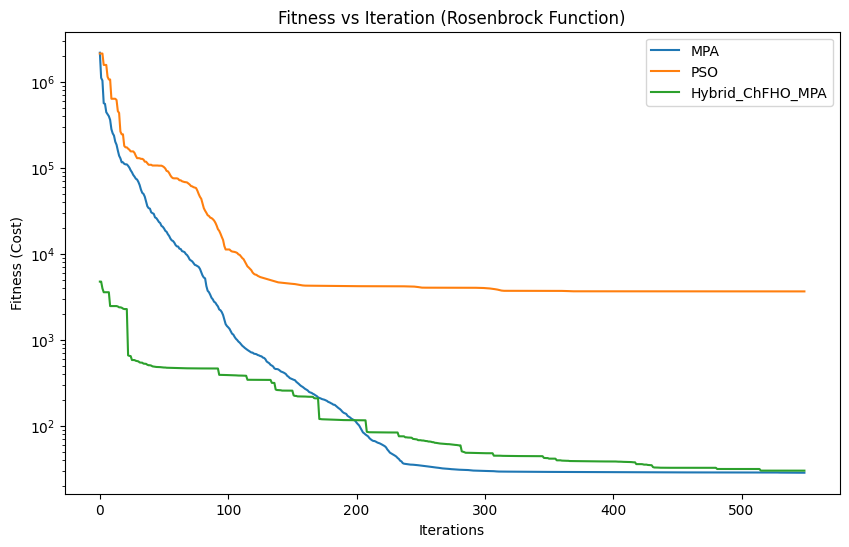

In [ ]:
# Define the plotting for each function
for func_name, problem_dict in problem_dicts.items():
    if func_name=="Griewank" or func_name=="Levy" or func_name=="Ackley" or func_name=="Rastrigin" or func_name=="Matyas":
      continue

    # # FHO Optimization
    # opti_FHO=FHO(minD,maxD,50,problem_dict['obj_func'],2000)
    # fitness_values_FHO = opti_FHO.minimize_FHO()



    # MPA Optimization
    fitness_values_MPA = run_optimization(MPA.OriginalMPA, problem_dict)

    # # PSO Optimization
    fitness_values_PSO = run_optimization(PSO.OriginalPSO, problem_dict)



    # Chaotic_FHO Optimization
    minD = problem_dict['bounds'].lb
    maxD = problem_dict['bounds'].ub
    # opti = Chaotic_FHO(minD, maxD, pop_size=70, cost_function=problem_dict['obj_func'], max_generations=550)
    # fitness_values_CFHO=opti.minimize_FHO()



    # Hybrid Algorithm Optimization
    fitness_values_hybrid = hybrid_chFHO_MPA(
        min_bounds=problem_dict['bounds'].lb,
        max_bounds=problem_dict['bounds'].ub,
        pop_size=50,
        cost_function=problem_dict['obj_func'],
        max_generations=550,
        # chFHO_iter=200  # Number of iterations for chFHO
    )
    # print(fitness_values_hybrid)




    # Plot results
    plot_performance({
        "MPA": fitness_values_MPA,
        "PSO": fitness_values_PSO,
        # "FHO": fitness_values_FHO,
        "Hybrid_ChFHO_MPA": fitness_values_hybrid
    }, f"Fitness vs Iteration ({func_name} Function)", "Fitness (Cost)", f"{func_name.lower()}_performance.png")